# Method 1 for time stepping

This adaptive time-stepping method considers the time derivative of the total energy 
for details: see Zhang, Z., & Qiao, Z. (2012). An Adaptive Time-Stepping Strategy for the Cahn-Hilliard Equation. Communications in Computational Physics, 11(4), 1261-1278. doi:10.4208/cicp.300810.140411s

$\triangle t=max(\triangle t_{min},\frac{\triangle t_{max}}{\sqrt{1+\alpha |\epsilon'(t)|^2}})$

# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time 
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
import math
import pyvista as pv
import pyfftw          # use for fast fourier transform
from scipy.fft import fft, ifft
from numba import jit  # use to speed up 
import scipy.stats as st

# Functions

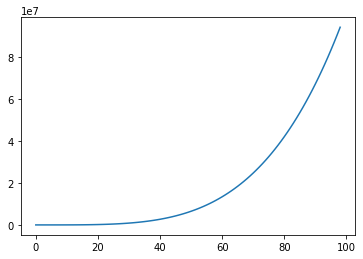

In [5]:
A=1
x=np.arange(1,100)
f=A*x**2*(1-x)**2

plt.plot(f)

In [2]:
def free_energ(c):
    A=1.0
    dfdc =A*(2.0*c*(1-c)**2 -2.0*c**2 *(1.0-c))
    return dfdc


#--------------------------------------------------------------------------------------------------

def fft_(a):
    """
    return a fft object from pyfftw library that will be use to compute fft
    """
    fft_object=pyfftw.builders.fftn(a,axes=(0,1,2), threads=12)
    return fft_object()
#--------------------------------------------------------------------------------------------------

def ifft_(a):
    """
    return a inverse fft object from pyfftw library that will be use to compute inverse fft
    """
    ifft_object=pyfftw.builders.ifftn(a,axes=(0,1,2), threads=12)
    return ifft_object()
#--------------------------------------------------------------------------------------------------
#@jit(nopython=True)
def micro_ch_pre(Nx,Ny,Nz,c0):
    c=np.zeros((Nx,Ny,Nz))
    noise=0.02
    for i_x in range(Nx):
        for i_y in range(Ny):
            for i_z in range(Nz):
                c[i_x,i_y,i_z] =c0 + noise*(0.5-np.random.rand())                 
    return c

# Compute energy evolution
"""
def calculate_energ(Nx,Ny,Nz,c,grad_coef):
    energ =0.0
    for i in range (Nx-1):
        ip = i + 1
        for j in range (Ny-1):
            jp = j + 1
            if (Nz>1):
                for l in range (Nz-1):
                    lp = l + 1 
                    energ += c[i,j,l]**2  *(1.0-c[i,j,l])**2  +  0.5*grad_coef*((c[ip,j,l]-c[i,j,l])**2 \
                          +(c[i,jp,l]-c[i,j,l])**2     + (c[i,j,lp]-c[i,j,l])**2)
            else:
                energ += c[i,j,0]**2  *(1.0-c[i,j,0])**2  +  0.5*grad_coef*((c[ip,j,0]-c[i,j,0])**2 \
                      +(c[i,jp,0]-c[i,j,0])**2) 
         
    return energ
"""
# Compute energy evolution
def calculate_energ(Nx,Ny,Nz,c,grad_coef):
    energ =0.0
    # ------------Nx------------------------------
    for i in range (Nx-1): 
        ip = i + 1
        #--------------Ny-------------------------
        if (Ny>1):
            for j in range (Ny-1):
                jp = j + 1
                # ----------Nz--------------------
                if (Nz>1): # 3D
                    for l in range (Nz-1):
                        lp = l + 1 
                        energ += c[i,j,l]**2  *(1.0-c[i,j,l])**2  +  0.5*grad_coef*((c[ip,j,l]-c[i,j,l])**2 \
                            +(c[i,jp,l]-c[i,j,l])**2     + (c[i,j,lp]-c[i,j,l])**2)
                        
                else: # (Nz==1) 2D
                        energ += c[i,j,0]**2  *(1.0-c[i,j,0])**2  +  0.5*grad_coef*((c[ip,j,0]-c[i,j,0])**2 \
                        +(c[i,jp,0]-c[i,j,0])**2) 
        else : # (Ny==1): 
            # ----------Nz--------------------
            if (Nz>1): # 2D
                 for l in range (Nz-1):
                     lp = l + 1
                     energ += c[i,0,l]**2  *(1.0-c[i,0,l])**2  +  0.5*grad_coef*((c[ip,0,l]-c[i,0,l])**2 \
                     + (c[i,0,lp]-c[i,0,l])**2)       
            else : # (Nz==1) 1D
                energ += c[i,0,0]**2  *(1.0-c[i,0,0])**2  +  0.5*grad_coef*(c[ip,0,0]-c[i,0,0])**2                         
         
    return energ
   
#---------------------------------------------------------------------------------------------------   
def infinite_norm(M):
    # suppose that Nz=1
    m=M.shape[0]
    n=M.shape[1]
    array_row_sum=[]
    for i in range(m):
        row_sum=0
        for j in range(n):
            row_sum+=np.abs(M[i,j,0])
        array_row_sum.append(row_sum)
    inf_norm=np.max(array_row_sum)
    return inf_norm
# compute 2D laplacian 
def laplacian_2D(c,i,j,l,dx,dy,dz):
    ip=i+1
    im=i-1
    jp=j+1
    jm=j-1
    if (im==-1):
        im=Nx-1
    if (ip==Nx):
        ip=0
    if (jm==-1):
        jm=Ny-1
    if (jp==Ny):
        jp=0
    hne=c[ip,j,0]
    hnw=c[im,j,0]
    hns=c[i,jm,0]
    hnn=c[i,jp,0]
    hnc=c[i,j,0]
    laplacian=(hnw+hne+hns+hnn-4*hnc)/(dx*dy) # uniform mesh
    return laplacian

# compute gradient
def gradient(c,i,j,l,dx,dy,dz):   
    Nx=c.shape[0]
    Ny=c.shape[1]
    Nz=c.shape[2]
    im=i-1
    jm=j-1
    lm=l-1
    if (im==-1):
        im=Nx-1
    if (jm==-1):
        jm=Ny-1
    if (lm==-1):
        lm=Nz-1

    hw=c[im,j,l]
    hs=c[i,jm,l]
    hz=c[i,j,lm]
    hc=c[i,j,l]

    grad_mu_x=(hc-hw)/dx
    grad_mu_y=(hc-hs)/dx
    grad_mu_z=(hc-hz)/dx

    return grad_mu_x,grad_mu_y,grad_mu_z
 
#---------------------------------------------------------------------------------------------------     
# compute residual at each time step (if istep >1), using Fourier space
def compute_residual_fft(array_energy,dtime, dfdck,ck,istep,k,k2, kappa,Nx,Ny,Nz):
    Nx=c.shape[0]
    Ny=c.shape[1]
    Nz=c.shape[2]
   
    # compute \mu
    mu=dfdck+kappa*(k2)*ck
    
    
    grad_mu=(1j*k)*mu
    
    sum_L2_square=0
    # compute Nabla(\mu) at each point grid and the associated L2 norm **2
    for i in range(Nx):
        for j in range(Ny):
            for l in range(Nz):
                grad_mu=np.array([ (1j*k[0,i,j,l])*mu[i,j,l] , (1j*k[1,i,j,l])*mu[i,j,l] , (1j*k[2,i,j,l])*mu[i,j,l] ])
                grad_mu=np.real(np.fft.ifft(grad_mu))
                sum_L2_square+=np.linalg.norm(grad_mu[:, :, 0], ord=2)**2
    #print(sum_L2_square)
    # A: energy derivative
    A=(array_energy[istep]-array_energy[istep-1])/dtime
    B= sum_L2_square
    RES=A+B
    print(RES)
    return RES,A,B


# -------------------------------------------------------------------
def compute_residual_fd(dtime, array_energy,array_dfdc,array_c, kappa,istep):
    sum_L2_square=0
    grad_mu=np.zeros((3,1))
    dfdc=array_dfdc[istep]
    dfdc_1=array_dfdc[istep-1]
    c=array_c[istep]
    c_1=array_c[istep-1]
    Nx=c.shape[0]
    Ny=c.shape[1]
    Nz=c.shape[2]
    mu=np.zeros((Nx,Ny,Nz))
    mu_p=np.zeros((Nx,Ny,Nz))
    mu_m=np.zeros((Nx,Ny,Nz))
    # compute \mu
    for i in range(Nx):
        for j in range(Ny):
            for l in range(Nz):
                mu_p[i,j,l]=dfdc[i,j,l]-kappa*laplacian_2D(c,i,j,l,dx_s,dy_s,dz_s)
                mu_m[i,j,l]=dfdc_1[i,j,l]-kappa*laplacian_2D(c_1,i,j,l,dx_s,dy_s,dz_s)
    mu=(mu_p+ mu_m)/2               
    # compute Nabla(\mu) at each point grid and the associated L2 norm **2
    for i in range(Nx):
        for j in range(Ny):
            for l in range(Nz):
                grad_mu_x,grad_mu_y,grad_mu_z=gradient(mu,i,j,l,dx_s,dy_s,dz_s)
                grad_mu=np.array([grad_mu_x,grad_mu_y,grad_mu_z])
                sum_L2_square+=np.linalg.norm(grad_mu, ord=2)**2
    # A: energy derivative
    A=(array_energy[istep]-array_energy[istep-1])/dtime
    B=sum_L2_square
    RES=A+B

    return RES, A, B

In [3]:
#---------------------------------------------------------------------------------------------------     
# compute residual at each time step (if istep >1), using Fourier space
def compute_residual_fft_test(array_energy,dtime, dfdck,ck,istep,k,k2, kappa,Nx,Ny,Nz):
    Nx=c.shape[0]
    Ny=c.shape[1]
    Nz=c.shape[2]
   
    # compute \mu
    mu=dfdck+kappa*(k2)*ck
    mu=np.real(np.fft.ifft(mu))
    
    sum_L2_square=0
    for i in range(Nx):
        for j in range(Ny):
            for l in range(Nz):
                grad_mu_x,grad_mu_y,grad_mu_z=gradient(mu,i,j,l,dx_s,dy_s,dz_s)
                grad_mu=np.array([grad_mu_x,grad_mu_y,grad_mu_z])
                sum_L2_square+=np.linalg.norm(grad_mu, ord=2)**2
    # A: energy derivative
    A=(array_energy[istep]-array_energy[istep-1])/dtime
    B=sum_L2_square
    RES=A+B
    print(RES)
    """
    grad_mu=(1j*k[0])*mu +(1j*k[1])*mu+(1j*k[2])*mu
    print( grad_mu.shape)
    sum_L2_square=np.linalg.norm(grad_mu[:, :, 0], ord=2)**2
    print(sum_L2_square)
    # compute Nabla(\mu) at each point grid and the associated L2 norm **2
    for i in range(Nx):
        for j in range(Ny):
            for l in range(Nz):
                grad_mu=np.array([ (1j*k[0,i,j,l])*mu[i,j,l] , (1j*k[1,i,j,l])*mu[i,j,l] , (1j*k[2,i,j,l])*mu[i,j,l] ])
                grad_mu=np.real(np.fft.ifft(grad_mu))
                sum_L2_square+=np.linalg.norm(grad_mu, ord=2)**2
    #print(sum_L2_square)
    # A: energy derivative
    A=(array_energy[istep]-array_energy[istep-1])/dtime
    B= sum_L2_square
    RES=A+B
    print(RES)
    """
    return RES,A,B

In [4]:
#RES, A, B=compute_residual_fft_test(array_energy,dtime, array_df_dc_k[nstep-1],ck,istep,k, k2,grad_coef,Nx,Ny,Nz)

In [5]:
# compute ND grad (Ny=Nz=1)
def gradient_ND(c,dx,dy,dz):
    Nx=c.shape[0]
    Ny=c.shape[1]
    Nz=c.shape[2]
    count_arr = np.bincount(np.array([Nx,Ny,Nz]))
    dim=3-count_arr[1] #  return problem dimension: 1D, 2D or 3D
    grad_ND=np.zeros((3,Nx,Ny,Nz)) 
    grad_ND_x=np.zeros((Nx,Ny,Nz))
    grad_ND_y=np.zeros((Nx,Ny,Nz))
    grad_ND_z=np.zeros((Nx,Ny,Nz))
    

    if (dim==1):
        for i in range(1,Nx):
            grad_ND_x[i,0,0]=(c[i,0,0]-c[i-1,0,0])/(dx)

    elif (dim==2):  # for simplification, we suppose that Nz=1
        for i in range(1,Nx):
            for j in range(1,Ny):
                grad_ND_x[i,j,0]=(c[i,j,0]-c[i-1,j,0])/(dx)
                grad_ND_y[i,j,0]=(c[i,j,0]-c[i,j-1,0])/(dy)

    else:   # 3D
        for i in range(1,Nx):
            for j in range(1,Ny):
                for l in range(1,Nz):
                    grad_ND_x[i,j,l]=(c[i,j,0]-c[i-1,j,0])/(dx)
                    grad_ND_y[i,j,l]=(c[i,j,0]-c[i,j-1,0])/(dy)
                    grad_ND_z[i,j,l]=(c[i,j,l]-c[i,j,l-1])/(dz)

    grad_ND[0,::]=grad_ND_x   
    grad_ND[1,::]=grad_ND_y 
    grad_ND[2,::]=grad_ND_z    

    return grad_ND


In [6]:
@jit(nopython=True)
def prepar_fft(Nx,dx,Ny,dy,Nz,dz,opt): 
    """
    Compute spatial frequence term and derivative
    """
    # variable initialisation
    lin_x=np.zeros(Nx)
    lin_y=np.zeros(Ny)
    lin_z=np.zeros(Nz)
        
    k=np.zeros((3,Nx,Ny,Nz))
    k2=np.zeros((Nx,Ny,Nz))
    k4=np.zeros((Nx,Ny,Nz))
        
    """
    # Method 1 to compute k  (3D)
    if (Nx % 2) == 1 : # = number odd if remainers is one
        lin_x[:int((Nx-1)/2.0+1)]=np.arange(0, int((Nx-1)/2.0+1), 1)*2*np.pi/(Nx*dx)
        lin_x[int((Nx-1)/2.0+1):]=np.arange(int(-(Nx+1)/2.0 +1), 0, 1)*2*np.pi/(Nx*dx)
    if (Ny % 2) == 1 :
        lin_y[:int((Ny-1)/2.0+1)]=np.arange(0, int((Ny-1)/2.0+1), 1)*2*np.pi/(Ny*dy)
        lin_y[int((Ny-1)/2.0+1):]=np.arange(int(-(Ny+1)/2.0 +1), 0, 1)*2*np.pi/(Ny*dy)
    if (Nz % 2) == 1 :
        lin_z[:int((Nz-1)/2.0+1)]=np.arange(0, int((Nz-1)/2.0+1), 1)*2*np.pi/(Nz*dz)
        lin_z[int((Nz-1)/2.0+1):]=np.arange(int(-(Nz+1)/2.0 +1), 0, 1)*2*np.pi/(Nz*dz)        
    if (Nx % 2) == 0 : # = number even if remainers is zero
        lin_x[0:int(Nx/2.0)]=np.arange(0, int(Nx/2.0), 1)*2*np.pi/(Nx*dx)
        lin_x[int(Nx/2.0 + 1):]=np.arange(int(-Nx/2.0 + 1), 0, 1)*2*np.pi/(Nx*dx)
    if (Ny % 2) == 0 :
        lin_y[0:int(Ny/2.0)]=np.arange(0, int(Ny/2.0), 1)*2*np.pi/(Ny*dy)
        lin_y[int(Ny/2.0 + 1):]=np.arange(int(-Ny/2.0 + 1), 0, 1)*2*np.pi/(Ny*dy)  
    if (Nz % 2) == 0 :
        lin_z[0:int(Nz/2.0)]=np.arange(0, int(Nz/2.0), 1)*2*np.pi/(Nz*dz)
        lin_z[int(Nz/2.0 + 1):]=np.arange(int(-Nz/2.0 + 1), 0, 1)*2*np.pi/(Nz*dz)          
    # grid   
    for i in range(Nx):
        for j in range(Ny):
            for l in range(Nz):
                 k[0,i,j,l]= lin_x[i]
                 k[1,i,j,l]= lin_y[j]
                 k[2,i,j,l]= lin_z[l]
     """
    # Method 2 to compute k      
    Lx=Nx*dx
    x=np.linspace(-0.5*Lx+dx,0.5*Lx,Nx)
    
    Ly=Ny*dy
    y=np.linspace(-0.5*Ly+dy,0.5*Ly,Ny)
    
    Lz=Nz*dz
    z=np.linspace(-0.5*Lz+dz,0.5*Lz,Nz)
         
    
    xx=2*np.pi/Lx*np.concatenate((np.arange(0,Nx/2+1), np.arange(-Nx/2+1,0)),axis=0)
    yy=2*np.pi/Ly*np.concatenate((np.arange(0,Ny/2+1), np.arange(-Ny/2+1,0)),axis=0)
    zz=2*np.pi/Lz*np.concatenate((np.arange(0,Nz/2+1), np.arange(-Nz/2+1,0)),axis=0)
        
    for i in range(Nx):
        for j in range(Ny):
            for l in range(Nz):
                k[0,i,j,l]= xx[i]
                k[1,i,j,l]= yy[j]
                k[2,i,j,l]= zz[l]           
                
    k2=k[0]**2+k[1]**2+k[2]**2
  
    k4=k2**2
         
    return k,k2,k4,x,y,z
def plot_micro(c,opt,ttime):
    # 1D case
    if (opt=='1D'):
        plt.plot(c[:, :, 0])
        plt.xlabel('x')
        plt.ylabel('concentration')
        plt.title('initial concentration')

    else: 
        # 2D or 3D cases--------------------------------------------------
        import sys
        grid  = pv.UniformGrid()
        grid.spacing=np.array([dx,dx,dx])*1E9
        grid.dimensions = np.array([Nx,Ny,Nz])#+1
        grid.point_arrays[r'c'] = np.transpose(np.resize(c,[Nx,Ny,Nz])).flatten()
        

        # Set a custom position and size
        sargs = dict(fmt="%.1f", color='black') 

        p = pv.Plotter()
        pv.set_plot_theme("ParaView")
        p.set_background("white")
        p.add_mesh(grid,show_scalar_bar=False,label='title')
        p.add_scalar_bar('Concentration', color='black',label_font_size=12, width=0.1, height=0.7, position_x=0.8,position_y=0.16,vertical= True, interactive=False)
        p.add_text('title')
        p.show_bounds(all_edges=True,xlabel="x [nm]",ylabel="y [nm]",zlabel="z [nm]",color='black')
        p.add_title('title')
        p.camera_position = [1, 1, 1]
        if (opt=='2D'):
            if (ttime==0):
                p.show(screenshot='Initial microstructure.png',cpos="xy") # cpos="xy" in case of 2D (Nz=1)
            else:
                p.show(screenshot='Microstructure at dimensionless time '+str('{0:.2f}'.format(ttime) )+ '.png',cpos="xy") #
        else:
            if (ttime==0):
                p.show(screenshot='Initial microstructure.png')    # 3D plot
                p.show(screenshot='Microstructure at dimensionless time '+str('{0:.2f}'.format(ttime) )+ '.png')    # 

In [7]:
# plot micro
def plot_micro(c,opt,ttime):
    # 1D case
    if (opt=='1D'):
        plt.plot(c[:, :, 0])
        plt.xlabel('x')
        plt.ylabel('concentration')
        plt.title('initial concentration')

    else: 
        # 2D or 3D cases--------------------------------------------------
        import sys
        grid  = pv.UniformGrid()
        grid.spacing=np.array([dx,dx,dx])*1E9
        grid.dimensions = np.array([Nx,Ny,Nz])#+1
        grid.point_arrays[r'c'] = np.transpose(np.resize(c,[Nx,Ny,Nz])).flatten()
        

        # Set a custom position and size
        sargs = dict(fmt="%.1f", color='black') 

        p = pv.Plotter()
        pv.set_plot_theme("ParaView")
        p.set_background("white")
        p.add_mesh(grid,show_scalar_bar=False,label='title')
        p.add_scalar_bar('Concentration', color='black',label_font_size=12, width=0.1, height=0.7, position_x=1,position_y=0.16,vertical= True, interactive=False)
        if (ttime==0):
            p.add_text('Initial Microstructure ',position='upper_edge',color='black',font= 'times',font_size=12)
        else:
            p.add_text('Microstructure at dimensionless time '+str('{0:.2f}'.format(ttime) ),color='black',font= 'times',font_size=12)

        p.show_bounds(all_edges=True,font_size=24,bold=True, xlabel="X [nm]",ylabel="Y [nm]",zlabel="Z [nm]",color='black')
        #p.add_title('Microstructure at dimensionless time '+str('{0:.2f}'.format(ttime) ))
        p.camera_position = [1, 1, 1]
        if (opt=='2D'):
            if (ttime==0):
                p.show(screenshot='Initial microstructure.png',cpos="xy") # cpos="xy" in case of 2D (Nz=1)
            else:
                p.show(screenshot='Microstructure at dimensionless time '+str('{0:.2f}'.format(ttime) )+ '.png',cpos="xy") #
        elif (opt=='3D'):
            if (ttime==0):
                p.show(screenshot='Initial microstructure.png') # cpos="xy" in case of 2D (Nz=1)
            else:
                p.show(screenshot='Microstructure at dimensionless time '+str('{0:.2f}'.format(ttime) )+ '.png') #

        p.close()

# Input Data

In [8]:
Nx=64 ; Ny=64; Nz=64

# spacing
dx=10e-10 # [m]
dy=10e-10 # [m]
dz=10e-10 # [m]

# convert into adimensional grid
dx_s=dx/dx
dy_s=dy/dy
dz_s=dz/dz


# Time stepping

Remind: This adaptive time-stepping method considers the time derivative of the total energy 


$\triangle t=max(\triangle t_{min},\frac{\triangle t_{max}}{\sqrt{1+\alpha |\epsilon'(t)|^2}})$

In [9]:
array_alpha=[10]
array_dt_min= [0.1]
array_dt_max=[2]


In [10]:
c0=0.4  #initial microstructure 
mobility =1.0
coefA = 1.0
grad_coef=0.5


# start simulation
t_start = time.time() 

#initialize microstructure
c= micro_ch_pre(Nx,Ny,Nz,c0)
c0_save=c

"""
#uncomment if necessary
# For comparison purposes: load the same initial microtructure as Matlab
# retrieving data from file.
loaded_arr = np.loadtxt("3D_micro_init.txt")

# This loadedArr is a 2D array, therefore
# we need to convert it to the original
# array shape.reshaping to get original
# matrice with original shape.
load_original_arr = loaded_arr.reshape(
loaded_arr.shape[0], loaded_arr.shape[1] // c.shape[2], c.shape[2])

c=load_original_arr
"""

'\n#uncomment if necessary\n# For comparison purposes: load the same initial microtructure as Matlab\n# retrieving data from file.\nloaded_arr = np.loadtxt("3D_micro_init.txt")\n\n# This loadedArr is a 2D array, therefore\n# we need to convert it to the original\n# array shape.reshaping to get original\n# matrice with original shape.\nload_original_arr = loaded_arr.reshape(\nloaded_arr.shape[0], loaded_arr.shape[1] // c.shape[2], c.shape[2])\n\nc=load_original_arr\n'

# plot initial microstructure

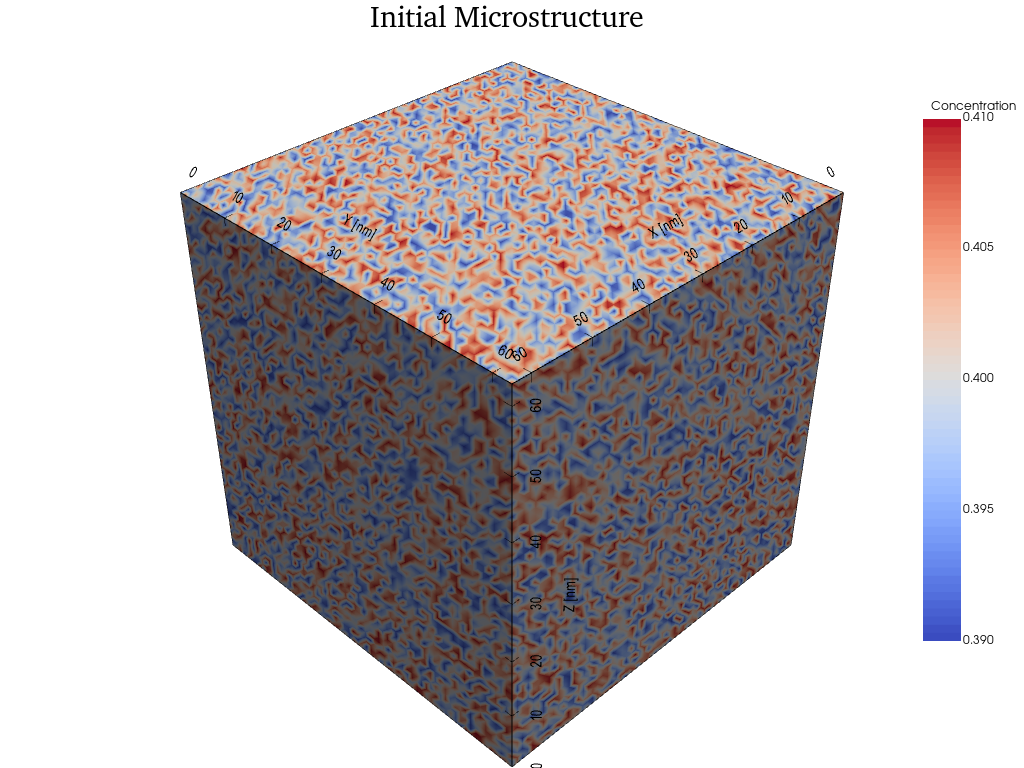

In [11]:
ttime=0
plot_micro(c0_save,'3D',ttime)


# Loop on time steps











simulation time : 5830.80775809288 seconds ---


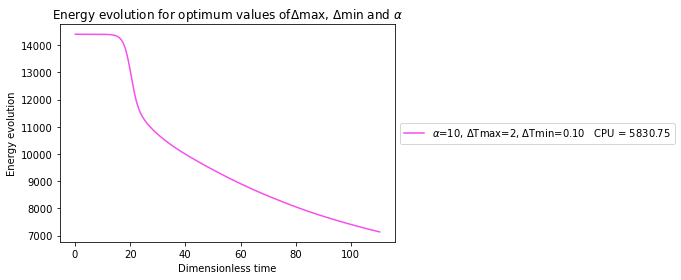

In [12]:
# loop to change time step (dtime) and compute associated energy dissipation for CH equation (at each time step) 
for index in range(len(array_dt_max)):    # to change alpha (or dtime_min or dtime_max) value in adaptive time stepping method 
    c=c0_save  # start with the same microstructure
    alpha=array_alpha[0]
    dt_max=array_dt_max[0]
    dt_min=array_dt_min[0]
    # time step and constant values
    ttime=0 # for each simulation 
    dtime=dt_min # dtime init
    #------------------
    # time steps and print parameters
    Nt=50 # trial 
    nstep= 1000 #int(round(Nt/dtime))
    endstep=nstep  # to change in loop ==> end simulation when some crietria are achieved (energy reachs a plateau)
    nprint=100; # step to print
    # set fourier coefficient 
    # compute the spatial frequency term from fft
    k,k2,k4,x,y,z=prepar_fft(Nx,dx_s,Ny,dy_s,Nz,dz_s,opt="3d")
    # initialize storage arrays
    
    array_time=np.zeros(nstep) 
    array_dtime=np.zeros(nstep)

    array_energy=np.zeros(nstep)     
    array_residus=np.zeros(nstep) 
    array_residus_fd=np.zeros(nstep)
    array_energy_deriv=np.zeros(nstep)     # default, computed in Fourier space
    array_energy_deriv_fd=np.zeros(nstep)  # "fd" computed by finite difference 
    array_energy_potentiel_grad=np.zeros(nstep) 
    array_energy_potentiel_grad_fd=np.zeros(nstep) 
    array_residual_deriv=np.zeros(nstep) 


    dfdc=np.zeros((Nx,Ny,Nz))
    array_df_dc_k=np.zeros((nstep,Nx,Ny,Nz))
    array_df_dc=np.zeros((nstep,Nx,Ny,Nz))
    array_c_k=np.zeros((nstep,Nx,Ny,Nz))
    array_c=np.zeros((nstep,Nx,Ny,Nz))

    residual_deriv=1  # default valuefor the stop criteria
    flag=0   # to stop simulation

    t_start = time.time() # to compute CPU for each simulation 
    #-------------------------------------------------
    for istep in range(nstep):
    #-------------------------------------------------
        ttime = ttime + dtime  
        array_dtime[istep]=dtime
        array_time[istep]=ttime
        
        # compute free energy 
        dfdc=free_energ(c)
            
        dfdck=fft_(dfdc) 
        ck=fft_(c)

        # Time integration
        numer=dtime*mobility*k2*dfdck
        denom = 1.0 + dtime*coefA*mobility*grad_coef*k4
        ck =(ck-numer)/denom
        
        c=np.real(ifft_(ck))   
        
        # for small deviations
        c[np.where(c >= 0.9999)]= 0.9999
        c[np.where(c <= 0.00001)]=0.00001  
        
        energy=calculate_energ(Nx,Ny,Nz,c,grad_coef)
        array_energy[istep]=energy
        array_df_dc_k[istep]=dfdck
        array_df_dc[istep]=dfdc
        array_c_k[istep]=ck
        array_c[istep]=c
        
        if (math.fmod(istep,nprint)==0):
           print()#plot_micro(c,'2D',ttime)

        # adaptive time stepping    
        if (istep>0):
            energy_derivative=(np.array(array_energy)[istep]-np.array(array_energy)[istep-1])/dtime
           
            dtime=np.max([dt_min,dt_max/np.sqrt(1+alpha*(energy_derivative**2))])
            #RE,energy_deriv,potentiel_grad=compute_residual_fft(array_energy,dtime, dfdck,ck,istep,k,k2, grad_coef,Nx,Ny,Nz)
            RE_fd,energy_deriv_fd,potentiel_grad_fd=compute_residual_fd(dtime, array_energy,array_df_dc,array_c, grad_coef,istep)
            #array_residus[istep]=RE
            #array_energy_deriv[istep]=energy_deriv
            #array_energy_potentiel_grad[istep]=potentiel_grad
            array_energy_deriv_fd[istep]=energy_deriv_fd
            array_energy_potentiel_grad_fd[istep]=potentiel_grad_fd
            array_residus_fd[istep]=RE_fd
        
            # criteria based on derivative of the energy residual
            residual_deriv=(array_residus[istep]-array_residus[istep-1])/array_dtime[istep]
            array_residual_deriv[istep]=residual_deriv  
            if (istep>1500): # (istep>200): by trial
                        residual_deriv_mean = np.mean([array_residual_deriv[j] for j in range(istep,istep-100,-1) ])  # a mean of derivatives   
                        energy_deriv_mean = np.mean([array_energy_deriv[j] for j in range(istep,istep-100,-1) ]) 
                        #print(residual_deriv_mean)
                        if (np.abs(energy_deriv_mean)<0.01) :  
                            print(istep,residual_deriv_mean)
                            flag=1
                            endstep=istep
                            break # break the for loop

                            

    #print('done istep: ', istep) 
    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------
    #-------------------------   Post processing   ------------------------------------
    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------        
    # plot energy evolution during spinodal deomposition
    #---------------------------------------------------------------------------------- 
    
    energ = np.array(array_energy)
    rgb = np.random.rand(3,)
    plt.plot(array_time[:endstep],energ[:endstep],label = r'$\alpha$='+str(alpha)+ ", "+ r'$\Delta$Tmax='+str(dt_max)+ ", "+ r'$\Delta$Tmin='+str('{0:.2f}'.format(dt_min))+"   CPU = "+ str('{0:.2f}'.format(time.time()-t_start)),color =rgb)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.title('Energy evolution for dt='+str('{0:.2f}'.format(dtime)))
    plt.xlabel('Dimensionless time')
    plt.ylabel('Energy evolution')
    #name='Energy evolution for different '+r'$\Delta$Tmax' + ' values' + ".png"
    #plt.savefig(name)
    #plt.title('Energy evolution for different ' +r'$\Delta$max'+ ' values')
    plt.title('Energy evolution for optimum values of'+ r'$\Delta$max'+ ', '+r'$\Delta$min'+ ' and ' + r'$\alpha$' )
    #plt.show()
    #----------------------------------------------------------------------------------        
    #plot solution evolution in space for (y=x) (2D)
    #---------------------------------------------------------------------------------- 
    """
    #transform array_time (time steps sauvegarded) from list to array
    array_time=np.array(array_time)
    
    # return index of time of plot (here the end of simulation is chossen)
    time_plot=int(np.array(np.where(abs(array_time - ttime)<0.001)))
    print(time_plot)
    #solution at the choosen instant 
    sol=array_c[time_plot]
    # extract diagonal of the matrix "sol"
    x_y_solution=np.diag(sol)
    plt.xlabel('y=x')
    plt.ylabel('Concentration at the end of simulation')
    rgb = np.random.rand(3,)
    plt.plot(x_y_solution,label = "dt="+str(dtime),color =rgb)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    """
    #----------------------------------------------------------------------------------        
    # plot evolution of infinite norm versus time 
    #---------------------------------------------------------------------------------
    """
    infinite_norm=[]
    array_c=np.array(array_c)
    for i in range (1,nstep):
        #compute infinite norm
        c_n=array_c[i]
        c_n__1=array_c[i-1]
        infinite_norm.append(np.max(c_n-c_n__1))
    infinite_norm=np.array( infinite_norm)  
    rgb = np.random.rand(3,)
    plt.plot(array_time,infinite_norm,label = r'$\alpha$='+str(alpha)+ ", "+ r'$\Delta$Tmax='+str(dt_max)+ ", "+ r'$\Delta$Tmin='+str(dt_min),color      =rgb)    
    plt.xlabel('t$^{n}$')
    plt.ylabel('||c$^{n}$ - c$^{n-1}$||$_{inf}$')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    """
    



print("simulation time : %s seconds ---" % (time.time() - t_start))

# Postprocess

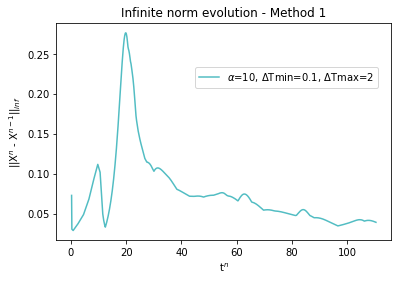

In [16]:
array_infinite_norm=[]
array_c=np.array(array_c)
for i in range (1,endstep):
    #compute infinite norm
    c_n=np.array(array_c[i])
    c_n__1=np.array(array_c[i-1])
    array_infinite_norm.append(infinite_norm(c_n-c_n__1))
array_infinite_norm=np.array(array_infinite_norm)  
rgb = np.random.rand(3,)
plt.plot(array_time[1:endstep],array_infinite_norm,label=r'$\alpha$=' +str(alpha)+  ", "+ r'$\Delta$Tmin='+str(dt_min)+ ", "+ r'$\Delta$Tmax='+str(dt_max),color      =rgb)  
plt.xlabel('t$^{n}$')
plt.ylabel('||X$^{n}$ - X$^{n-1}$||$_{inf}$')
plt.title('Infinite norm evolution - Method 1')
plt.legend(loc='center left', bbox_to_anchor=(0.4, 0.75))
plt.show()

In [77]:
# save energy_vs_time in txt file : for comparative purposes
np.savetxt('energy_method_1.txt',energ[:endstep], fmt=' %.2f')
np.savetxt('time_method_1.txt',array_time[:endstep], fmt=' %.2f')

#energ_fd =np.loadtxt("energy_fd.txt",  delimiter=" ", unpack=False)

Text(0.5, 1.0, 'Time step evolution - Method 1')

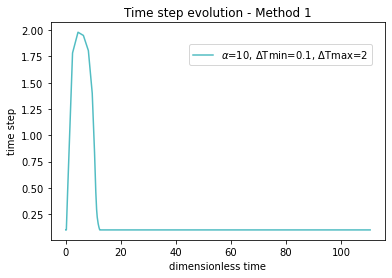

In [17]:
# plot dtime versus time evolution
plt.plot(array_time[:endstep],array_dtime[:endstep],label=r'$\alpha$=' +str(alpha)+  ", "+ r'$\Delta$Tmin='+str(dt_min)+ ", "+ r'$\Delta$Tmax='+str(dt_max),color      =rgb)  
plt.legend(loc='center left', bbox_to_anchor=(0.4, 0.85))
plt.xlabel('dimensionless time')
plt.ylabel('time step') 
plt.title('Time step evolution - Method 1')

Text(0, 0.5, 'Energy evolution')

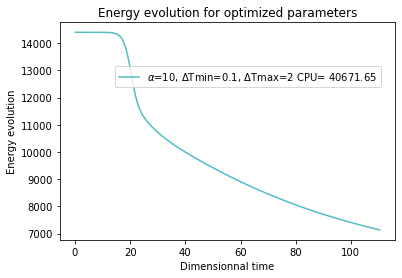

In [18]:
# Energy evolution
CPU=time.time() - t_start
energ = np.array(array_energy[:endstep])
plt.plot(array_time[:nstep],energ[:endstep],label=r'$\alpha$=' +str(alpha)+  ", "+ r'$\Delta$Tmin='+str(dt_min)+ ", "+ r'$\Delta$Tmax='+str(dt_max)+" CPU= "+str('{0:.2f}'.format(CPU)),color      =rgb)
plt.legend(loc='center left', bbox_to_anchor=(0.15, 0.75))
plt.title('Energy evolution for optimized parameters')
plt.xlabel('Dimensionnal time')
plt.ylabel('Energy evolution')


Text(0.5, 1.0, 'Energy residual evolution - Method 1')

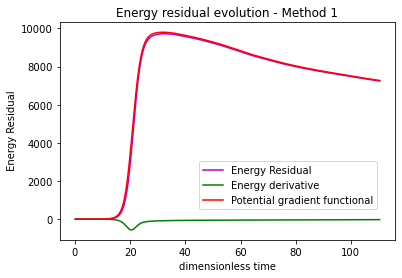

In [19]:
# plot dtime versus time evolution
#plt.plot(array_time,array_residus, label='Residus (FFT)',c='b')
plt.plot(array_time,array_residus_fd, label='Energy Residual',c='m')
#plt.plot(array_time,array_energy_deriv, label='Energy derivative',c='g')
plt.plot(array_time,array_energy_deriv_fd, label='Energy derivative',c='g')
#plt.plot(array_time,array_energy_potentiel_grad, label='Potentioel gradient functional',c='r')
plt.plot(array_time,array_energy_potentiel_grad_fd, label='Potential gradient functional',c='r')
plt.legend(loc='center left', bbox_to_anchor=(0.4, 0.25))
plt.xlabel('dimensionless time')
plt.ylabel(' Energy Residual') 
plt.title('Energy residual evolution - Method 1')

In [197]:
# save energy_vs_time in txt file : for comparative purposes
n_lines=energ.shape[0]
energy_time_adap=np.ones((n_lines,2))
energy_time_adap[:,0]=timesteps
energy_time_adap[:,1]=energ

np.savetxt('energy_versus_time_adaptive.txt', energy_time_adap, fmt='%.2f')

NameError: name 'timesteps' is not defined

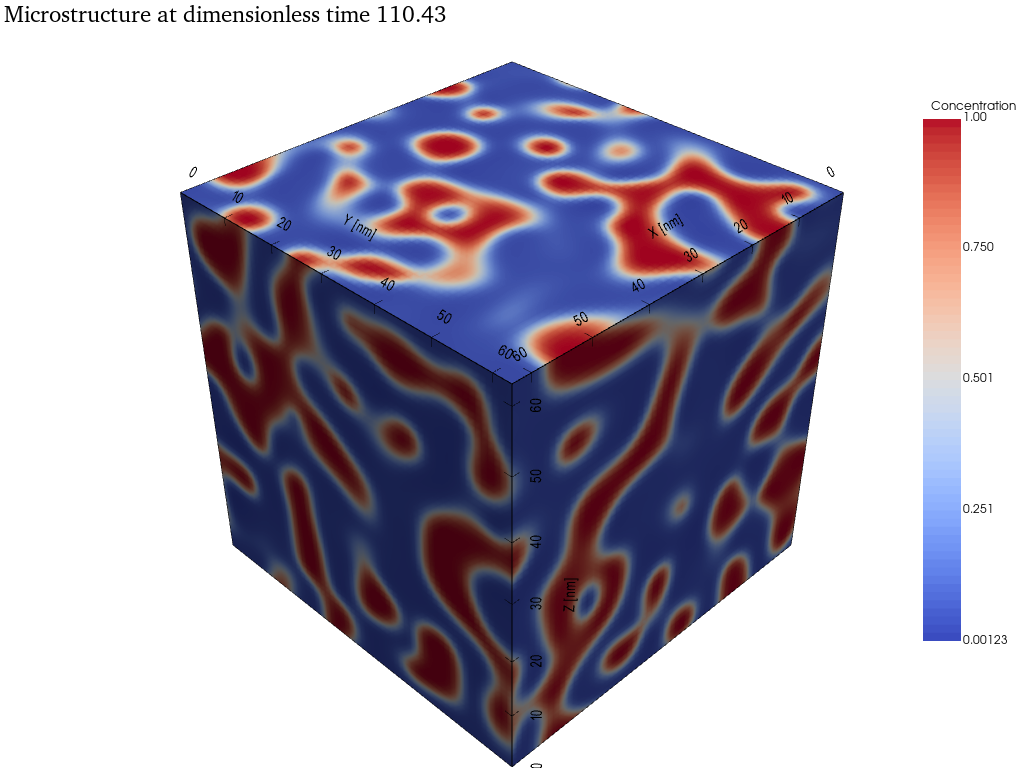

In [14]:
#plot actual microstructure
plot_micro(c,'3D',ttime)

In [15]:
#plot actual microstructure
plot_mayavi(c,'3D',ttime)
plot_m

NameError: name 'plot_mayavi' is not defined